In [4]:
import pandas as pd
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import pyxdf
import mne
import os
import sklearn
#%matplotlib qt

In [5]:
def xdf_to_dataframe(xdf_data):
    ''' Xdf Data should be a list of streams (dictionaries)
        Function returns a dictionary of dataframes, one dataframe per stream'''
    dataframes = {}
    for stream in xdf_data:
        df = pd.DataFrame()
        data = stream['time_series']
        timestamps = stream['time_stamps']
        df['Time'] = timestamps
        chan_names, units = get_channel_names(stream['info'])
        counts = data.shape[0]
        for series, name, unit in zip(range(data.shape[1]), chan_names, units):
            df[name[0]]  = data[:, series]
            if unit:
                df[name[0] + '_Unit'] = np.repeat(unit, counts)

        for item in stream['info']:
            if item not in ['name', 'desc', 'data']:
                try:
                    df[item] = np.repeat(stream['info'][item], counts)
                except:
                    continue
        dataframes[stream['info']['name'][0]] = df
    return dataframes

def get_channel_names(info):
    channels = info['desc'][0]['channels'][0]['channel']
    names = [chan['label'] for chan in channels ]
    units = [chan['unit'] for chan in channels ]
    return names, units

In [6]:
directory = 'Data'
participants = ['Jin']
xdf_files = ['Continuous_1.xdf','Continuous_2.xdf','Continuous_3.xdf','Fist_1.xdf', 'Fist_2.xdf','Fist_3.xdf', 'Left_20_1.xdf','Left_20_2.xdf','Left_20_3.xdf','Left_50_1.xdf','Left_50_2.xdf','Left_50_3.xdf','PalmUp_1.xdf','PalmUp_2.xdf','PalmUp_3.xdf','Right_30_1.xdf','Right_30_2.xdf','Right_30_3.xdf','Right_80_1.xdf','Right_80_2.xdf','Right_80_3.xdf',]
csv_files = ['Continuous_1.csv','Continuous_2.csv','Continuous_3..csv','Fist_1.csv', 'Fist_2.csv','Fist_3.csv', 'Left_20_1.csv','Left_20_2.csv','Left_20_3.csv','Left_50_1.csv','Left_50_2.csv','Left_50_3.csv','PalmUp_1.csv','PalmUp_2.csv','PalmUp_3.csv','Right_30_1.csv','Right_30_2.csv','Right_30_3.csv','Right_80_1.csv','Right_80_2.csv','Right_80_3.csv',]
for participant in participants:
    newfile = 0
    for file in xdf_files:
        data, header = pyxdf.load_xdf(os.path.join(directory, participant, file))
        data_dfs = xdf_to_dataframe(data)
        data_dfs['Thalmic Labs MyoMyo'].to_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_data.columns = myo_data.columns.str.replace(' ', '')
        newfile += 1


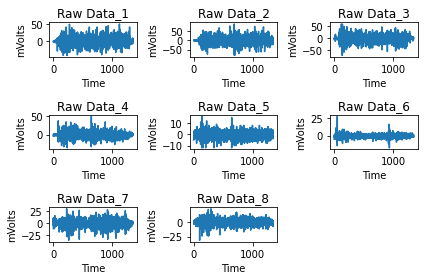

In [7]:
'''code used to look at 8 channels of raw data'''
import matplotlib.pyplot as plt
plt.figure()
for channel in range(1,9):
    plt.subplot(3,3,channel)
    ax = myo_data['EMG_' + str(channel)].plot()
    plt.title('Raw Data_' + str(channel))
    plt.ylabel('mVolts')
    plt.xlabel('Time')
    plt.tight_layout()

In [8]:
import scipy as sp
import scipy.signal

def filteremg(emg, low_pass=3, sfreq=200, high_band=20, low_band=95):
    # Zero mean emg signal
    emg = emg - emg.mean()
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    # create lowpass filter and apply to rectified signal to get EMG envelope
    #low_pass = low_pass/(sfreq/2)
    b2, a2 = sp.signal.butter(4, low_pass, fs=sfreq, btype='lowpass')
    emg_envelope = sp.signal.lfilter(b2, a2, emg_rectified)
    return emg_envelope

def notchfilter(emg, sfreq=256, notch_freq = 60, quality_factor = 20):
    b_notch, a_notch = sp.signal.iirnotch(notch_freq, quality_factor, sfreq)
    output = sp.signal.filtfilt(b_notch, a_notch, emg)
    return output

In [9]:
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)
        #plt.figure()
        #for channel in range(1,9):
            #plt.subplot(3,3,channel)
            #ax = myo_notch['EMG_' + str(channel)].plot()
            #plt.title('Total Filter_' + str(channel))
            #plt.ylabel('mVolts')
            #plt.xlabel('Time')
            #plt.tight_layout()
        newfile += 1

In [11]:
'''Extract the PSD and find the Max Power of each sample and signal'''
PSD=[]
PSD_Row = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

        '''Copy the myo_notch files'''
        myo_PSD = myo_notch.copy() #Copy the notched data into PSD
        #myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        for channel in range(1,9):
            Freq, P_Den = sp.signal.periodogram(myo_PSD['EMG_'+str(channel)],200)
            bigP_Den = max(P_Den)
            T_bigP_Den = np.transpose(bigP_Den)
            PSD_Row.append(T_bigP_Den)
            '''This get all 8 channel max PSD'''
        newfile += 1
        PSD.append([PSD_Row])
        '''Add the channel into an list'''
        PSD_Row = [] #Reset the TempRow
PSD_df= pd.DataFrame(PSD,columns=['MaxPSD_1'])
PSD_df_1= pd.DataFrame(PSD_df['MaxPSD_1'].tolist()).add_prefix('Max_PSDCh')
display(PSD_df_1)



,Max_PSDCh0,Max_PSDCh1,Max_PSDCh2,Max_PSDCh3,Max_PSDCh4,Max_PSDCh5,Max_PSDCh6,Max_PSDCh7
0,3.657406,5.286873,1.876386,0.996251,0.364433,3.300803,27.858801,4.846876
1,3.186482,7.013025,1.180754,0.480326,0.165374,3.208705,23.227835,2.811765
2,1.524346,3.775054,0.603047,0.201814,0.123434,1.952963,18.604942,1.888234
3,7.652409,0.870480,1.253394,0.163127,0.524881,4.889725,1.258820,2.036323
4,5.993175,0.916624,1.370589,0.064929,0.371108,4.699208,0.257998,0.825740
5,11.189908,1.430859,2.469341,0.133657,0.532599,5.552706,1.926788,2.557298
6,0.019743,0.005509,0.001627,0.001724,0.003490,0.142551,3.337406,0.097002
7,0.003730,0.001209,0.001250,0.002526,0.002793,0.021635,2.222792,0.063459
8,0.013423,0.024849,0.001691,0.006873,0.002456,0.053068,0.532777,0.040841
9,0.116335,0.308228,0.052171,0.085083,0.014595,0.397565,3.268047,0.366218


In [25]:
'''Exctract Mean signals'''
Mean_df=[]
Mean_Temp = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

        '''Copy the myo_notch files'''
        myo_Mean = myo_notch.copy() #Copy the notched data into PSD
        #myo_data_keys = ['EMG_' + str(i) for i in range(1, 9)] #for bio its ran3ge (1,5)
        for channel in range(1,9):
            '''Add the Mean code here'''
            Mean_1 = np.mean(myo_Mean['EMG_'+str(channel)]) #Extracgt one channel of the mean
            '''This get all 8 channel max PSD'''
            Mean_Temp.append(Mean_1)
        newfile += 1
        Mean_df.append([Mean_Temp])
        Mean_Temp = [] #Reset the TempRow
display(Mean_df)
Mean_df= pd.DataFrame(Mean_df,columns=['avg'])
display(Mean_df)
Mean_df_1= pd.DataFrame(Mean_df['avg'].tolist()).add_prefix('Mean_Ch')
display(Mean_df_1)


[[[0.6168267104926471,
   0.692844791843114,
   0.45410091375720696,
   0.3984010616416865,
   0.2945416364585111,
   0.6582980138329572,
   1.7689103306752387,
   0.8764933872029936]],
 [[0.7098212767089692,
   0.9661014858909512,
   0.4541761630724731,
   0.36398923762534185,
   0.26544318475320217,
   0.668303314210059,
   1.8278881083982583,
   0.7485832748858212]],
 [[0.7462439172294038,
   0.968981022014303,
   0.45845644629572485,
   0.3641467653467136,
   0.27540670332903977,
   0.5653850050101004,
   1.5519531963838928,
   0.7644941469795794]],
 [[2.461753291481406,
   0.8843668088463501,
   1.0489416432597216,
   0.4814698818466594,
   0.7491862179852972,
   2.038326241456547,
   1.4676866333823022,
   1.522724220787487]],
 [[1.8528222964806629,
   0.7247863064268911,
   0.8479929685992114,
   0.36458761252829325,
   0.5130265774808761,
   1.459985287287841,
   1.2401718625415503,
   1.0487637075280092]],
 [[1.5048858606027422,
   0.6072918725804626,
   0.7545835739486411,
  

,avg
0,"[0.6168267104926471, 0.692844791843114, 0.4541..."
1,"[0.7098212767089692, 0.9661014858909512, 0.454..."
2,"[0.7462439172294038, 0.968981022014303, 0.4584..."
3,"[2.461753291481406, 0.8843668088463501, 1.0489..."
4,"[1.8528222964806629, 0.7247863064268911, 0.847..."
5,"[1.5048858606027422, 0.6072918725804626, 0.754..."
6,"[0.16477691315284598, 0.10259669341262793, 0.0..."
7,"[0.1370789229634748, 0.09450485331716377, 0.09..."
8,"[0.19864020324002016, 0.17372329706633324, 0.1..."
9,"[0.721238081645779, 1.010141173558149, 0.44444..."


,Mean_Ch0,Mean_Ch1,Mean_Ch2,Mean_Ch3,Mean_Ch4,Mean_Ch5,Mean_Ch6,Mean_Ch7
0,0.616827,0.692845,0.454101,0.398401,0.294542,0.658298,1.768910,0.876493
1,0.709821,0.966101,0.454176,0.363989,0.265443,0.668303,1.827888,0.748583
2,0.746244,0.968981,0.458456,0.364147,0.275407,0.565385,1.551953,0.764494
3,2.461753,0.884367,1.048942,0.481470,0.749186,2.038326,1.467687,1.522724
4,1.852822,0.724786,0.847993,0.364588,0.513027,1.459985,1.240172,1.048764
5,1.504886,0.607292,0.754584,0.281294,0.450479,1.227114,1.261233,0.961252
6,0.164777,0.102597,0.098781,0.107912,0.142083,0.413540,1.566955,0.346430
7,0.137079,0.094505,0.098676,0.107568,0.144000,0.442288,1.734248,0.352231
8,0.198640,0.173723,0.108088,0.138981,0.145696,0.520637,2.089172,0.412986
9,0.721238,1.010141,0.444450,0.526285,0.311496,1.104577,3.773786,1.021250


In [28]:
'''Standard Deviation'''
#std
std=[]
std_Row = []
for participant in participants:
    newfile = 0
    for file in xdf_files:
        myo_data = pd.read_csv(os.path.join(directory, participant, csv_files[newfile]))
        myo_filtered = myo_data.copy()
        myo_datakeys = ['EMG' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_filtered[myo_data_keys] = myo_filtered[myo_data_keys].apply(filteremg, sfreq = 256, high_band=20, low_band=95, raw=True)
        myo_notch = myo_filtered.copy()
        myo_datakeys = ['EMG' + str(i) for i in range(1, 9)] #for bio its range (1,5)
        myo_notch[myo_data_keys] = myo_notch[myo_data_keys].apply(notchfilter, raw=True)
        #myo_notch.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)
        '''Copy the myo_notch files'''
        myo_STD= myo_notch.copy() #Copy the notched data
        for channel in range(1,9):
            std_temp = np.std(myo_STD['EMG_'+str(channel)])
            T_std_temp = np.transpose(std_temp)
            std_Row.append(T_std_temp)
            '''This get all 8 channel max PSD'''
        newfile += 1
        std.append([std_Row])
        std_Row = [] #Reset the TempRow
std_df= pd.DataFrame(std,columns=['STD'])
std_df_1= pd.DataFrame(std_df['STD'].tolist()).add_prefix('STD_Ch')
display(std_df_1)

,STD_Ch0,STD_Ch1,STD_Ch2,STD_Ch3,STD_Ch4,STD_Ch5,STD_Ch6,STD_Ch7
0,0.751556,0.922453,0.495821,0.397194,0.251179,0.699411,1.727297,0.985318
1,0.643551,1.084592,0.427150,0.258649,0.180439,0.695048,1.637093,0.741558
2,0.616178,0.954646,0.388222,0.258937,0.193924,0.601925,1.632898,0.711564
3,1.598083,0.538037,0.697017,0.272103,0.452000,1.225126,0.717386,0.824354
4,1.307164,0.483155,0.558576,0.154024,0.293552,0.966567,0.442312,0.554177
5,1.283871,0.481421,0.619158,0.157426,0.291940,0.908751,0.595076,0.643937
6,0.082071,0.046922,0.036009,0.032963,0.042683,0.209884,0.893496,0.196601
7,0.050085,0.028896,0.033830,0.048953,0.046327,0.156390,0.905133,0.169012
8,0.077725,0.095585,0.041495,0.086850,0.041326,0.182460,0.602319,0.176196
9,0.268773,0.401137,0.176747,0.263126,0.128547,0.465652,1.251062,0.433582


In [41]:
'''Merg all three features into a big ass dataframe'''
Feature_df = pd.concat([PSD_df_1,Mean_df_1,std_df_1],axis=1,join = 'outer')
display(Feature_df)


,Max_PSDCh0,Max_PSDCh1,Max_PSDCh2,Max_PSDCh3,Max_PSDCh4,Max_PSDCh5,Max_PSDCh6,Max_PSDCh7,Mean_Ch0,Mean_Ch1,...,Mean_Ch6,Mean_Ch7,STD_Ch0,STD_Ch1,STD_Ch2,STD_Ch3,STD_Ch4,STD_Ch5,STD_Ch6,STD_Ch7
0,3.657406,5.286873,1.876386,0.996251,0.364433,3.300803,27.858801,4.846876,0.616827,0.692845,...,1.768910,0.876493,0.751556,0.922453,0.495821,0.397194,0.251179,0.699411,1.727297,0.985318
1,3.186482,7.013025,1.180754,0.480326,0.165374,3.208705,23.227835,2.811765,0.709821,0.966101,...,1.827888,0.748583,0.643551,1.084592,0.427150,0.258649,0.180439,0.695048,1.637093,0.741558
2,1.524346,3.775054,0.603047,0.201814,0.123434,1.952963,18.604942,1.888234,0.746244,0.968981,...,1.551953,0.764494,0.616178,0.954646,0.388222,0.258937,0.193924,0.601925,1.632898,0.711564
3,7.652409,0.870480,1.253394,0.163127,0.524881,4.889725,1.258820,2.036323,2.461753,0.884367,...,1.467687,1.522724,1.598083,0.538037,0.697017,0.272103,0.452000,1.225126,0.717386,0.824354
4,5.993175,0.916624,1.370589,0.064929,0.371108,4.699208,0.257998,0.825740,1.852822,0.724786,...,1.240172,1.048764,1.307164,0.483155,0.558576,0.154024,0.293552,0.966567,0.442312,0.554177
5,11.189908,1.430859,2.469341,0.133657,0.532599,5.552706,1.926788,2.557298,1.504886,0.607292,...,1.261233,0.961252,1.283871,0.481421,0.619158,0.157426,0.291940,0.908751,0.595076,0.643937
6,0.019743,0.005509,0.001627,0.001724,0.003490,0.142551,3.337406,0.097002,0.164777,0.102597,...,1.566955,0.346430,0.082071,0.046922,0.036009,0.032963,0.042683,0.209884,0.893496,0.196601
7,0.003730,0.001209,0.001250,0.002526,0.002793,0.021635,2.222792,0.063459,0.137079,0.094505,...,1.734248,0.352231,0.050085,0.028896,0.033830,0.048953,0.046327,0.156390,0.905133,0.169012
8,0.013423,0.024849,0.001691,0.006873,0.002456,0.053068,0.532777,0.040841,0.198640,0.173723,...,2.089172,0.412986,0.077725,0.095585,0.041495,0.086850,0.041326,0.182460,0.602319,0.176196
9,0.116335,0.308228,0.052171,0.085083,0.014595,0.397565,3.268047,0.366218,0.721238,1.010141,...,3.773786,1.021250,0.268773,0.401137,0.176747,0.263126,0.128547,0.465652,1.251062,0.433582


In [ ]:
'''Time to do PCA'''



In [ ]:
#pca

#svm
#kmeans

#rf rand forest

#confusion matrix
#accuracy